# Shallow Water Finite Volume Models

It is recommended to run all these notebooks at least once, in order to generate all required modules.


## Schemes considering horizontal bottom

### Dambreak analytical solution

[dambreak.ipynb](dambreak.ipynb)

The first analytical solution we tried for validating our schemes.

It generates the module **dambreak.py**, which contains routines to obtain this solution given some parameters.

### First order scheme

[nswe_order1.ipynb](nswe_order1.ipynb)

An implementation of a shock capturing first order scheme. It also contains a discussion of instabilities observed in numerical experiments for the dambreak solution with dry bottom and open or closed boundary conditions.

It requires the module **dambreak.py**.

It generates the module **nswe1.py**, which contains the implementation of this solver.

### Second order scheme

[nswe_muscl_2order.ipynb](nswe_muscl_2order.ipynb)

It uses the same FV formulation but with second order MUSCL reconstruction of variables. Here is also a discussion about the MUSCL slope limiters, and some quick numerical tests.

It requieres the module **nswe1.py** (for comparison).

It generates the module **muscl2.py**.

### Fourth order scheme

[nswe_muscl_4order.ipynb](swe_muscl_4order.ipynb)

[nswe_muscl_4order_reconstruct_u.ipynb](nswe_muscl_4order_reconstruct_u.ipynb)

Same FV formulation with a fourth order MUSCL reconstruction. I am not very sure of what all the differences between these two are, but at least the second one uses h and u as main variables (whereas the other uses h and hu). This is an improvement made to avoid many "divide by h" operations. 

It also tries to compare with the 4th order well balanced scheme and for that reason it is not using limiters, so that's why the dambreak case turns very oscillatory near the discontinuity and then unstable.

To execute cells starting from [39] you will need the **nswe_wbmuscl4.py** module.

It does not generate any module.

## Schemes considering non-horizontal bottom (Well-balanced schemes)

All of these schemes are 4th order in time, using a RK scheme.

### Second order WB scheme

[nswe_wbmuscl2.ipynb](nswe_wbmuscl2.ipynb)

[nswe_wbmuscl2_handu.ipynb](nswe_wbmuscl2_handu.ipynb)

Implementation of the well balanced scheme that uses the hydrostatic reconstruction to preserve steady states at rest. There is also a comparison between Euler and RK4 schemes. 

The second one uses h and u as main variables, whereas the other uses h and hu. This is not a difference in the scheme, but only in the computer implementation.

It also contains a quick DB case that illustrates that wall boundaries defined as topography work well, opposite to what happened with the horizontal bottom case. The second notebook also shows other toy case to see the interaction with a step and variable slope.

It generates the module **nswe_wbmuscl2.py**.

** Please run the second notebook to generate this module, since it is more stable than the first one**

### Validation tests for the WB2 scheme

[nswe_wbmuscl2_handu_tests.ipynb](nswe_wbmuscl2_handu_tests.ipynb)

[nswe_wbmuscl2_tests.ipynb](nswe_wbmuscl2_handu_tests.ipynb) **not working**

Tests considered:
* Lake at rest
* Incident sinusoidal wave (boundary condition)
* Incident sinusoidal wave over a beach with slope
* Subcritical flow over a bump (analytical solution at steady state)

It requires the **nswe_wbmuscl2.py** module.

Tests look successful.


### Fourth order scheme

[nswe_wbmuscl4.ipynb](nswe_wbmuscl4.ipynb)

It implements the same fourth order scheme as with horizontal bottom but without using limiters, and using the 2nd order hydrostatic reconstruction and source balancing strategy. Also shows two validation cases at the end which look successful.

It generates the **nswe_wbmuscl4.py** module.

### Comparison of WB schemes

[nswe_wbcomparison.ipynb](nswe_wbcomparison.ipynb)

Test case for comparing the WB2 and WB4 schemes. Here the  "subcritical flow over a bump" is used where the evolution of the global numerical error is compared. It is also confirmed that the 4th order scheme has a smaller error compared to the 2nd order scheme.

It requires the **nswe_wbmuscl2.py** and **nswe_wbmuscl4.py** modules.


# Test cases for comparison of the 2nd and 4th order WB schemes

* [wb2 model here](nswe_wbmuscl2_handu.ipynb)
* [wb4 model here](nswe_wbmuscl4.ipynb)

In [1]:
import nswe_wbmuscl2 as wb2
import nswe_wbmuscl4 as wb4

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Subcritical flow over a bump

Defined as Section 6.2 in the paper of Berthon an Marche (2008).

## Boundary conditions

We need boundary conditions that may allow us to set a fixed discharge and water height at the boundaries.

### Second order scheme

To set values directly into ghost cells

In [3]:
def bcs_inflow2(d,h0,u0,hin,qin,t,dt):
    """ 
        incident wave height at the left boundary
        open at the right boundary
    """
    uin = qin/hin
    db = 1.*d
    hb = 1.*h0
    ub = 1.*u0
    
    for i in range(2):
        db[i] = db[2]
        hb[i] = hin
        ub[i] = uin
    
    for i in range(2):
        db[-i-1] = db[-3]
        hb[-i-1] = hin
        ub[-i-1] = uin    
    return db,hb,ub

Boundary condition using characteristics can be found in function
    
    wb2.bcs_inflow
    
which uses the scheme explained in the paper by Mignot and Cienfuegos (2009).

### Fourth order

To set values directly into ghost cells

In [4]:
def bcs_inflow4(d,h0,u0,hin,qin,t,dt):
    """ 
        incident wave height at the left boundary
        open at the right boundary
    """
    uin = qin/hin
    
    db = 1.*d
    hb = 1.*h0
    ub = 1.*u0
    
    for i in range(3):
        db[i] = db[3]
        hb[i] = hin
        ub[i] = uin
    
    for i in range(3):
        db[-i-1] = db[-4]
        hb[-i-1] = hin
        ub[-i-1] = uin    
    return db,hb,ub

Using characteristics, following the scheme explained in the paper by Mignot and Cienfuegos (2009).

In [5]:
#%%writefile nswe_wbmuscl4.py -a 

def bcs_inflow4_car(d,h0,u0,hin,qin,t,dt):
    """ 
        incident wave height at the left boundary
        open at the right boundary
    """
    hl  = hin
    hul = qin
    ul = hul/hl
    hr = h0[3]
    ur = u0[3]
    
    Rlplus = ul + 2.*np.sqrt(9.81*hl)
    Rrminus = ur - 2.*np.sqrt(9.81*hr)
    
    ua = 0.5*(Rlplus + Rrminus)
    ha = 1./(16.*9.81)*(Rlplus-Rrminus)**2
    
    db = 1.*d
    hb = 1.*h0
    ub = 1.*u0
    
    for i in range(3):
        db[i] = db[3]
        hb[i] = hl
        ub[i] = ul
    
    hr = hin
    ur = qin/hin
    hl = h0[-4]
    ul = u0[-4]

    Rlplus = ul + 2.*np.sqrt(9.81*hl)
    Rrminus = ur - 2.*np.sqrt(9.81*hr)

    ua = 0.5*(Rlplus + Rrminus)
    ha = 1./(16.*9.81)*(Rlplus-Rrminus)**2

    for i in range(3):
        db[-i-1] = db[-4]
        hb[-i-1] = hr
        ub[-i-1] = ur
    
    return db,hb,ub

## Setup of the simulation

Function that defines the topography

$$ b(x) = \begin{cases}
0.2 - 0.05(x-10)^2 & \textit{ if } x\in(8,12) \\
0.0 & \textit{ else }
\end{cases}$$

In [6]:
def b(x):
    d0 = np.where((x>8)*(x<12), 0.2-0.05*(x-10.)**2, 0.0)
#     d0 = 0.2*np.exp(-(x-10)**2/2.)
    return d0

Simulation parameters, geometry and initial condition using $H_0 = 2.0 m$ and $q_0 = 4.42$

(0, 2.1)

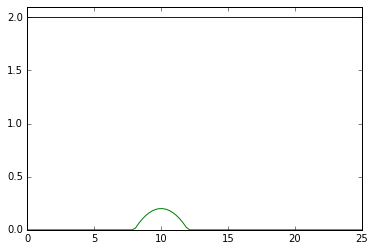

In [7]:
#t params
cfl = 1.0
nt = 300
t0 = 0.0

#x params
nx = 100
x = np.linspace(0,25,nx)
dx = np.diff(x)[0]

#topo
d0 = b(x)

#height
H0 = 2.
h0 = H0-d0

#velocity
q0 = 4.42
hu0 = np.ones_like(x)*q0
u0 = q0/h0

plt.plot(x,h0+d0)
plt.plot(x,d0)
plt.ylim(0,2.1)

Simulation with the second order scheme

In [8]:
t2, h2, u2 = wb2.sim_rk4(h0, u0, d0, nt, nx, cfl, dx, bcs=wb2.bcs_inflow, bcargs=[H0,q0])

nswe_wbmuscl2.py:372: RuntimeWarning: invalid value encountered in divide
  u2 = np.where( h2>hmin, (h[n,:]*u[n,:]+0.5*k1[1,:]*dt)/h2, 0.0)
nswe_wbmuscl2.py:376: RuntimeWarning: invalid value encountered in divide
  u3 = np.where(h3>hmin, (h[n,:]*u[n,:]+0.5*k2[1,:]*dt)/h3, 0.0)
nswe_wbmuscl2.py:380: RuntimeWarning: invalid value encountered in divide
  u4 = np.where(h4>hmin, (h[n,:]*u[n,:]+k3[1,:]*dt)/h4, 0.0)
nswe_wbmuscl2.py:385: RuntimeWarning: invalid value encountered in divide
  u[n+1,:] = np.where(h[n+1,:]>hmin, hu/h[n+1,:], 0.0)


Simulation with the fourth order scheme **without limiters** 
* **There is a bug: when using limiters we get numerical errors (figures in next section) that are worse than with the second order scheme**
* ** To debug, check lines 40-44 of function wb4.get4thMusclLimitedReconstruction**

In [9]:
t4, h4, u4 = wb4.solve_rk4(d0,h0,u0,bcs_inflow4_car,dx,cfl,t0,nt,1e-10,wb4.roe,bcargs=[H0,q0])

Animation of the second order scheme


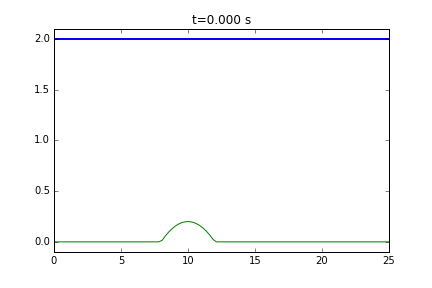
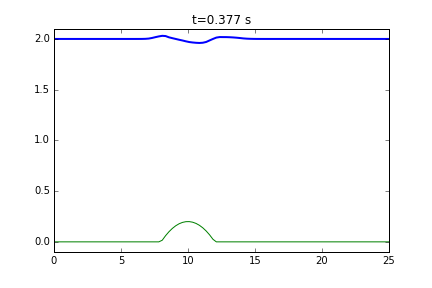
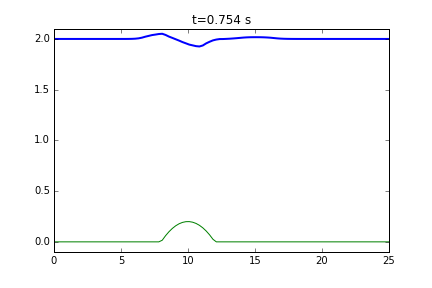
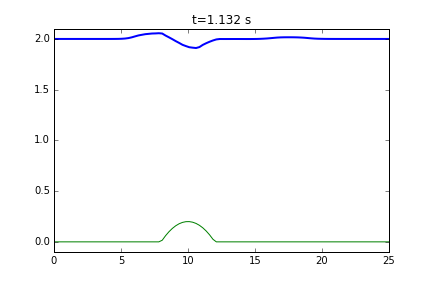
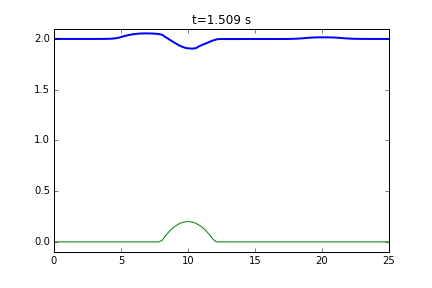
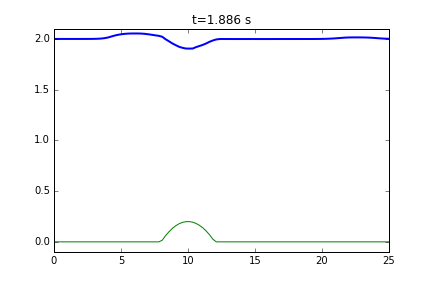
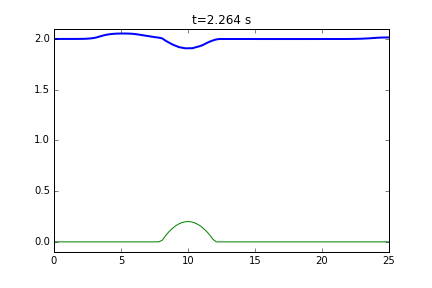
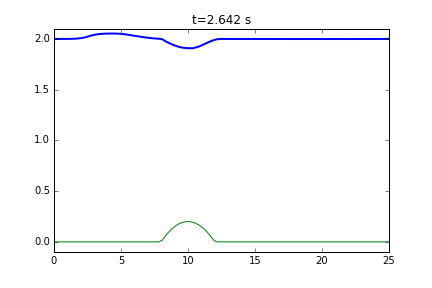
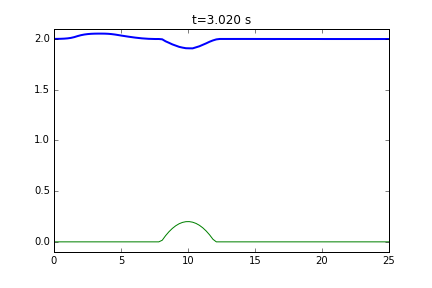
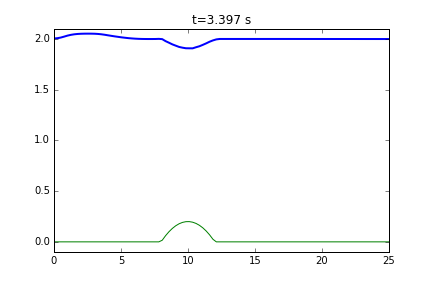
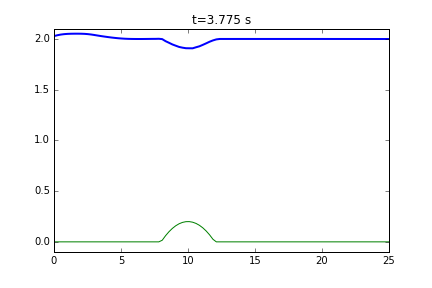
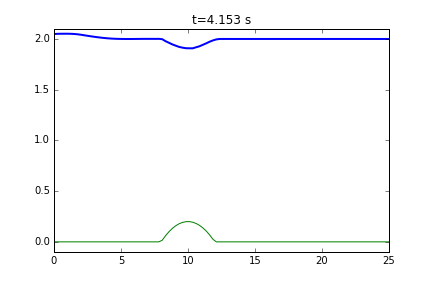
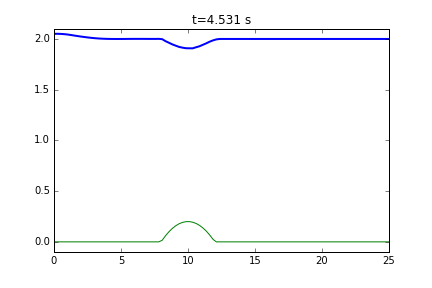
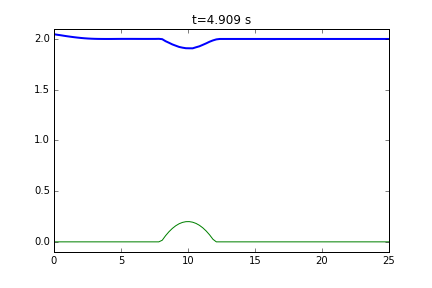
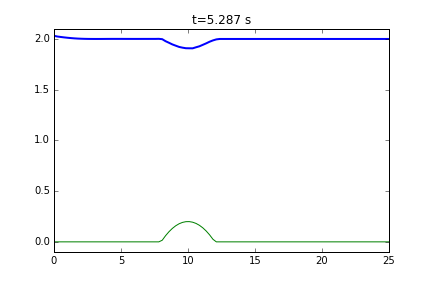
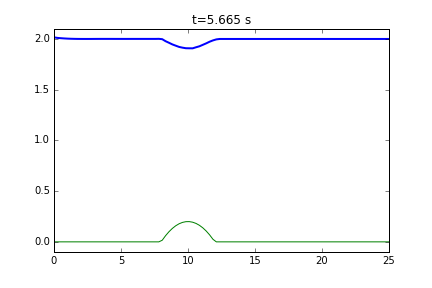
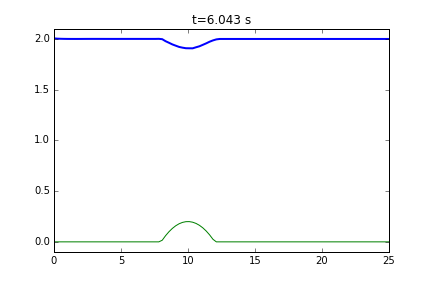
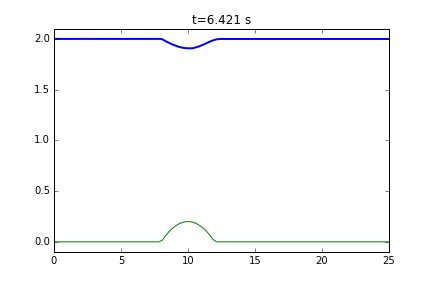
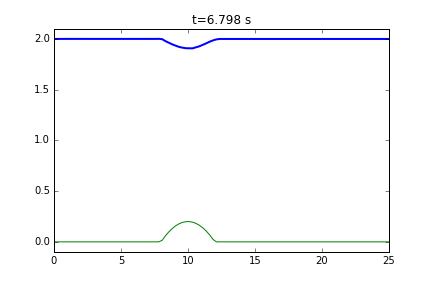
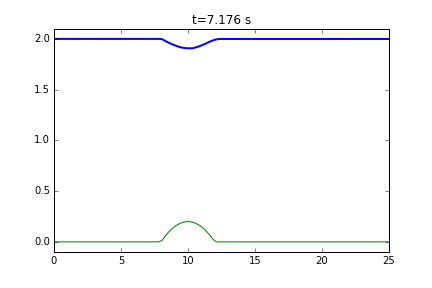
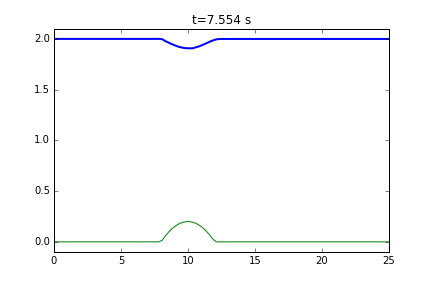
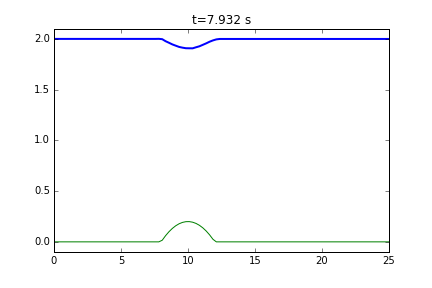
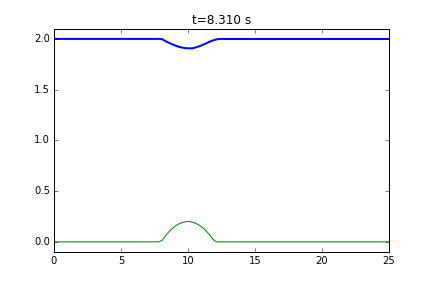
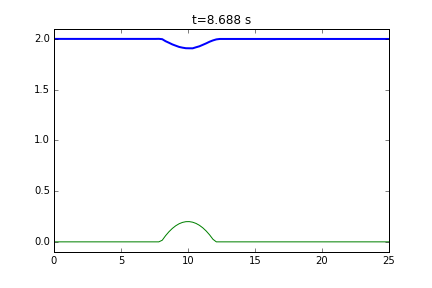
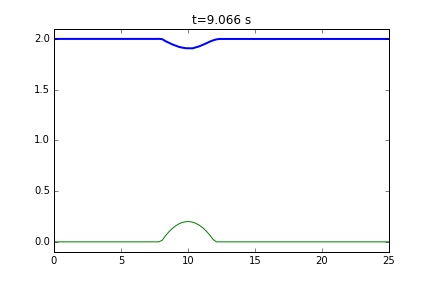
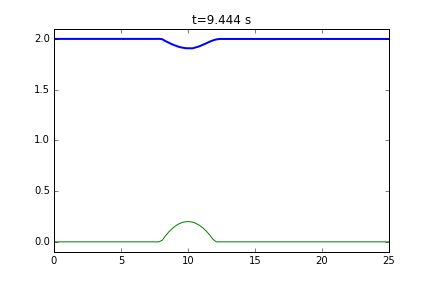
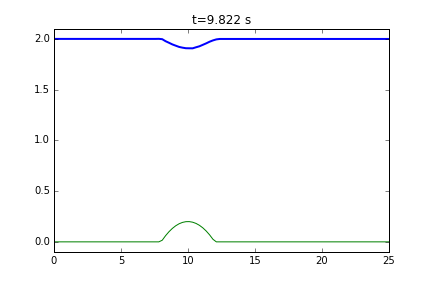
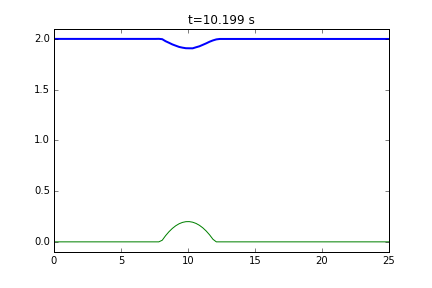
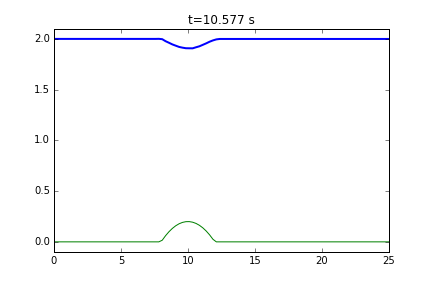
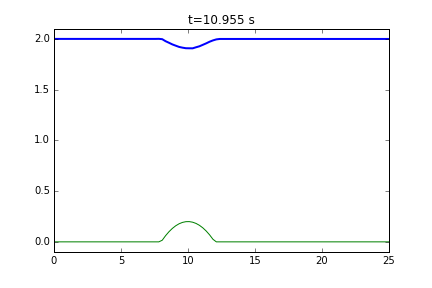

In [10]:
from matplotlib import animation
from JSAnimation import IPython_display

fig = plt.figure()
ax = plt.axes(xlim=(0, 25), ylim=(-0.1,2.1))
line, = ax.plot([], [], '-',lw=2)
lineb, = ax.plot(x,d0)
timetxt = ax.set_title('t=')

def animate(i):
    i = min(i*10,nt-1)
    line.set_data(x, h2[i,2:-2]+d0)
    timetxt.set_text('t=%.3f s'%t2[i])
    return line,

animation.FuncAnimation(fig, animate, frames=nt/10, interval=45)

Animation with the fourth order scheme


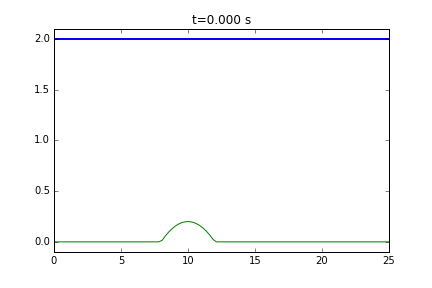
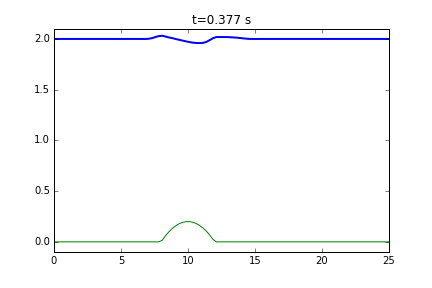
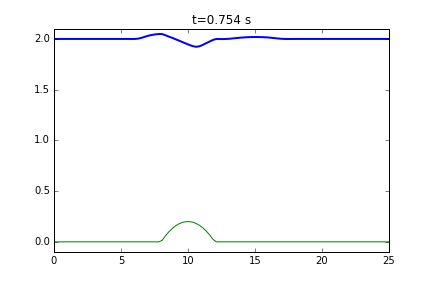
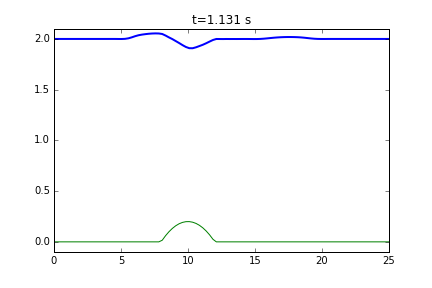
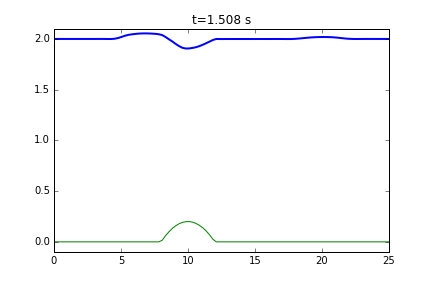
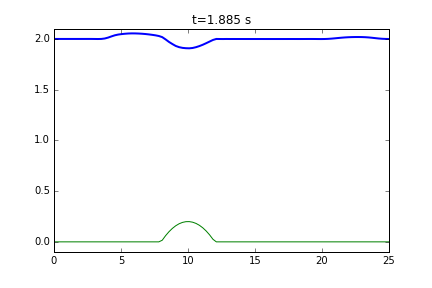
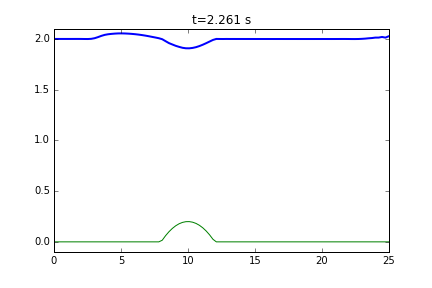
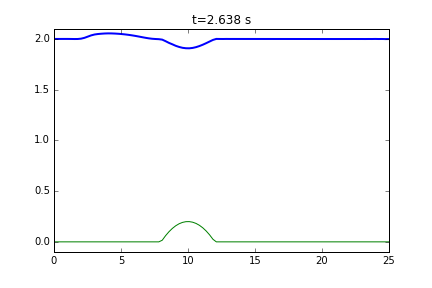
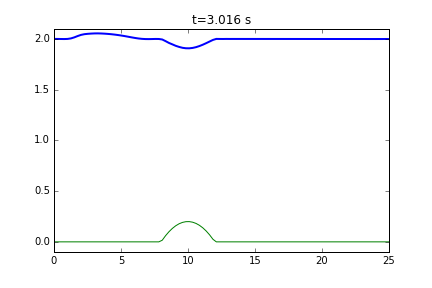
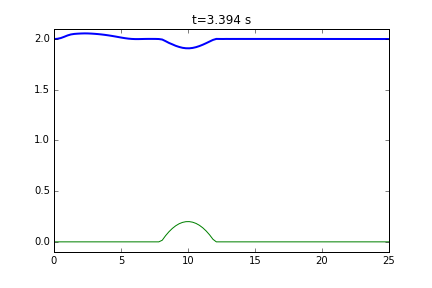
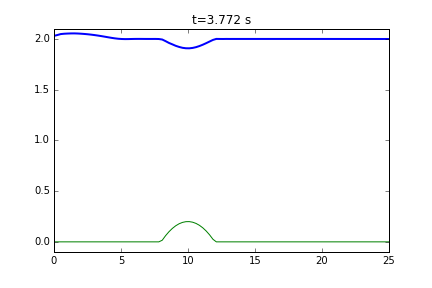
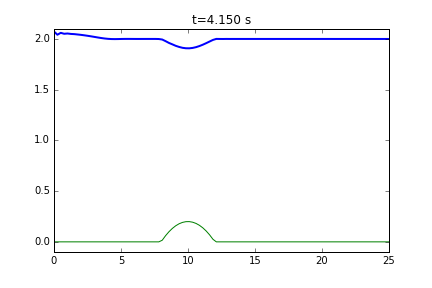
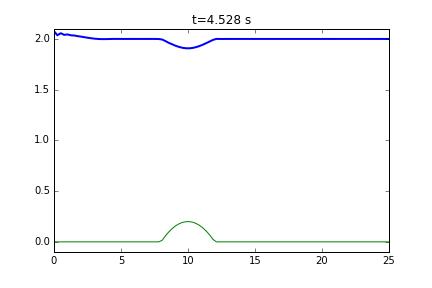
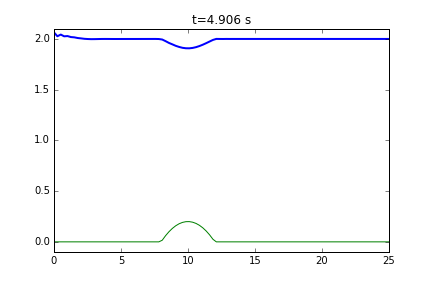
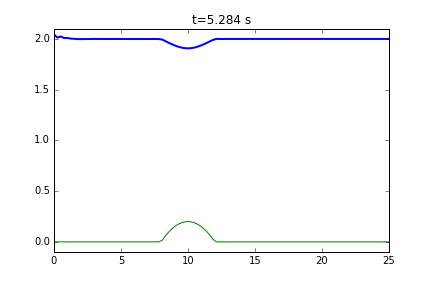
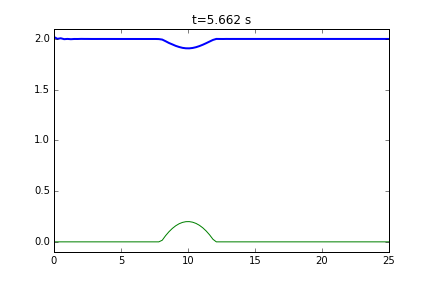
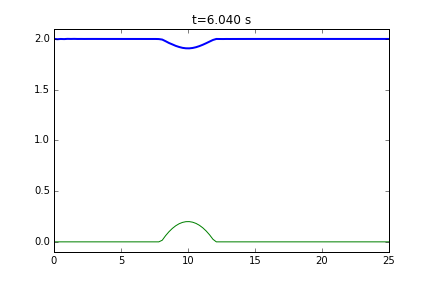
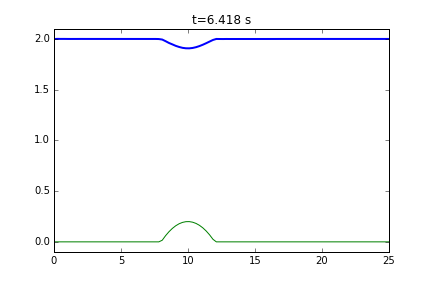
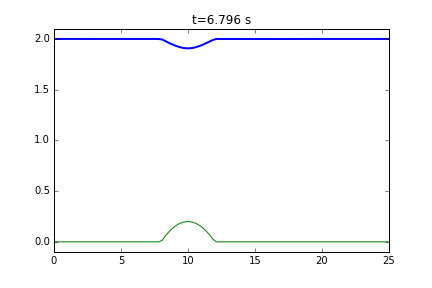
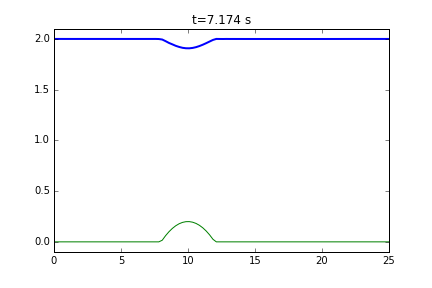
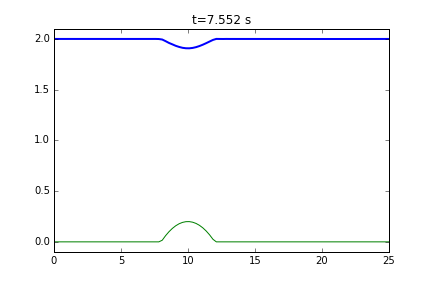
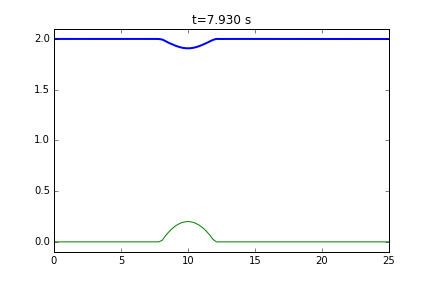
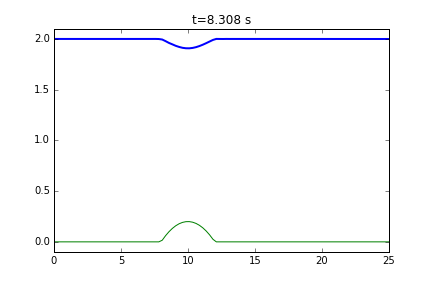
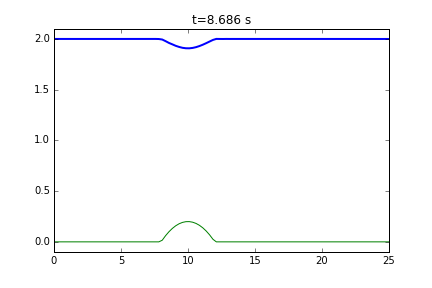
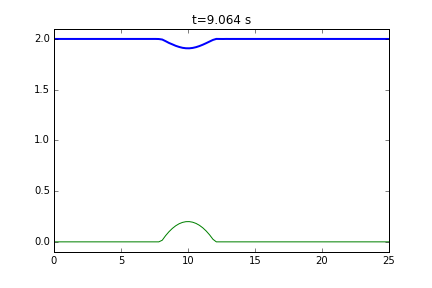
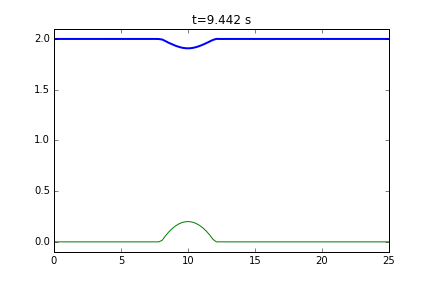
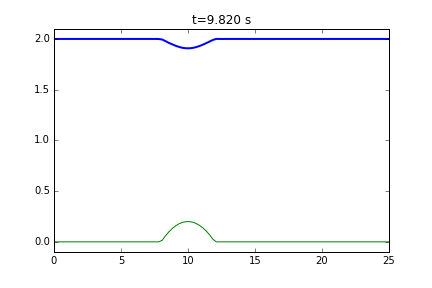
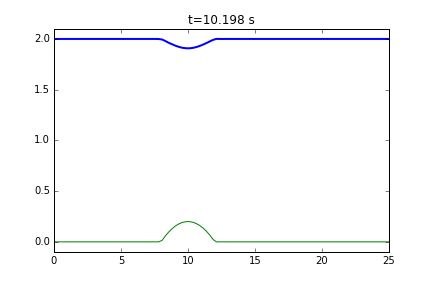
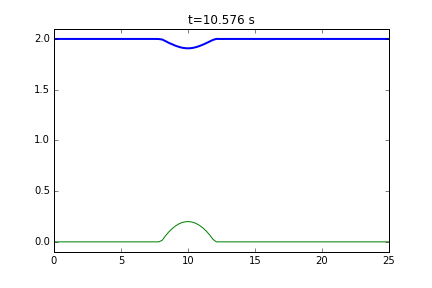
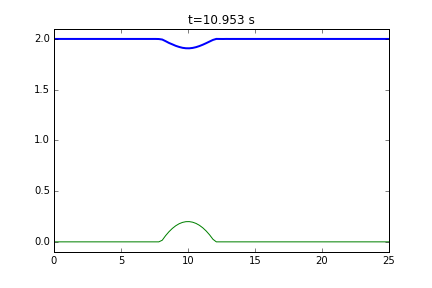

In [11]:
fig = plt.figure()
ax = plt.axes(xlim=(0, 25), ylim=(-0.1,2.1))
line, = ax.plot([], [], '-',lw=2)
lineb, = ax.plot(x,d0)
timetxt = ax.set_title('t=')

def animate(i):
    i = min(i*10,nt-1)
    line.set_data(x, h4[i,3:-3]+d0)
    timetxt.set_text('t=%.3f s'%t4[i])
    return line,

animation.FuncAnimation(fig, animate, frames=nt/10, interval=45)

## Analytical solution

The analytical solution is given by the relations

\begin{align} 
h(x) + b(x) + \frac{q_0^2}{2gh(x)} &= H_0 + b(0) + \frac{q^2}{2gH_0} \\
h(x)u(x) &= q_0 
\end{align}

with $q_0$ and $H_0$ the given constants that represent the flow in the channel and water level at the boundary

In [12]:
from scipy.optimize import fsolve
def tosolve(h,x,q,H0):
    eq = h + b(x) + q**2/(2.*9.81*h**2) - (H0+b(0)+q**2/(2.*9.81*H0**2))
    return eq
ha = np.array([fsolve(tosolve,H0,args=(x[i],q0,H0),xtol=1e-15) for i in range(x.shape[0])])
ua = q0/ha

Compare the obtained steady states

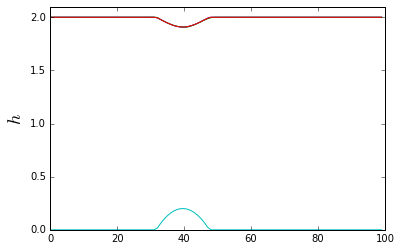

In [13]:
plt.plot(ha[:,0]+d0,label='analytical');
plt.plot(h2[-1,2:-2]+d0,label='wb2')
plt.plot(h4[-1,3:-3]+d0,label='wb4')
plt.plot(d0,label='topo')
plt.ylim(0,2.1)
plt.ylabel(r'$h$',fontsize=18)


Compute $L_2$ errors as 

$$ E_\phi = ||\phi^{num} - \phi^{sol}||_{L_2} \approx = \left(\sum_{i=0}^{n} (\phi_i^{num} - \phi_i^{sol})^2 \Delta x \right)^{1/2}$$

### Error in h

In [14]:
Eh_wb2 = np.zeros(nt)
Eh_wb4 = np.zeros(nt)
for i in range(nt):
    Eh_wb2[i] = np.sqrt(np.sum((h2[i,2:-2]-ha[:,0])**2*dx))/np.sqrt(np.sum((ha)**2*dx))
    Eh_wb4[i] = np.sqrt(np.sum((h4[i,3:-3]-ha[:,0])**2*dx))/np.sqrt(np.sum((ha)**2*dx))


Plot the evolution of the $L_2$ error for $h$, $E_{h(t)}$

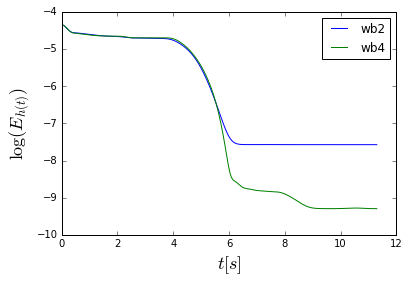

In [15]:
plt.plot(t2,np.log(Eh_wb2),label='wb2')
plt.plot(t4,np.log(Eh_wb4),label='wb4')
plt.legend(loc=0)
plt.xlabel(r'$t [s]$',fontsize=18)
plt.ylabel(r'$\log(E_{h(t)})$',fontsize=18)


### Error in u

In [16]:
Eu_wb2 = np.zeros(nt)
Eu_wb4 = np.zeros(nt)
for i in range(nt):
    Eu_wb2[i] = np.sqrt(np.sum((u2[i,2:-2]-ua[:,0])**2*dx))/np.sqrt(np.sum((ua)**2*dx))
    Eu_wb4[i] = np.sqrt(np.sum((u4[i,3:-3]-ua[:,0])**2*dx))/np.sqrt(np.sum((ua)**2*dx))


Plot the evolution of the $L_2$ error for $u$, $E_{u(t)}$

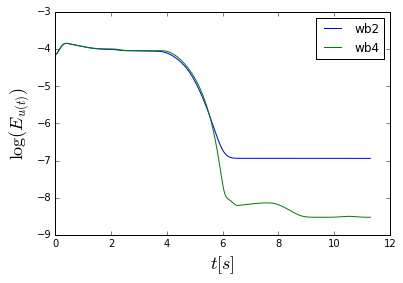

In [17]:
plt.plot(t2,np.log(Eu_wb2),label='wb2')
plt.plot(t4,np.log(Eu_wb4),label='wb4')
plt.legend(loc=0)
plt.xlabel(r'$t [s]$',fontsize=18)
plt.ylabel(r'$\log(E_{u(t)})$',fontsize=18)

### Error in hu

In [18]:
Ehu_wb2 = np.zeros(nt)
Ehu_wb4 = np.zeros(nt)
for i in range(nt):
    Ehu_wb2[i] = np.sqrt(np.sum((u2[i,2:-2]*h2[i,2:-2]-q0)**2*dx))/q0
    Ehu_wb4[i] = np.sqrt(np.sum((u4[i,3:-3]*h4[i,3:-3]-q0)**2*dx))/q0


/home/jose/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/home/jose/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


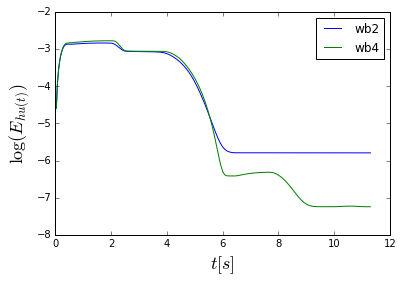

In [19]:
plt.plot(t2,np.log(Ehu_wb2),label='wb2')
plt.plot(t4,np.log(Ehu_wb4),label='wb4')
plt.legend(loc=0)
plt.xlabel(r'$t [s]$',fontsize=18)
plt.ylabel(r'$\log(E_{hu(t)})$',fontsize=18)

On the three figures above the wb4 scheme is better than the wb2. The first 6 seconds the error looks very similar since it comes from the unsteady state, not from the numerics.

### An animation without showing the topography


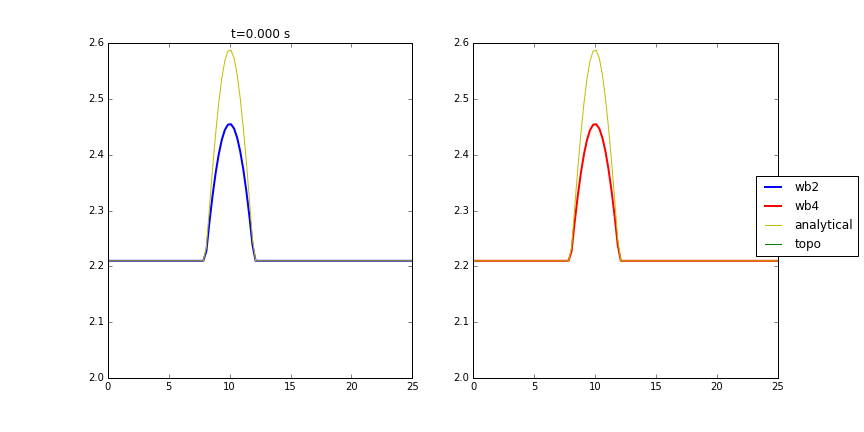
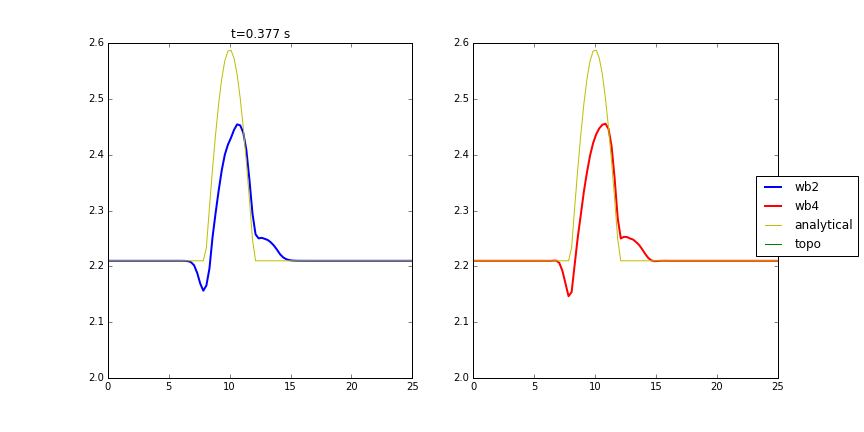
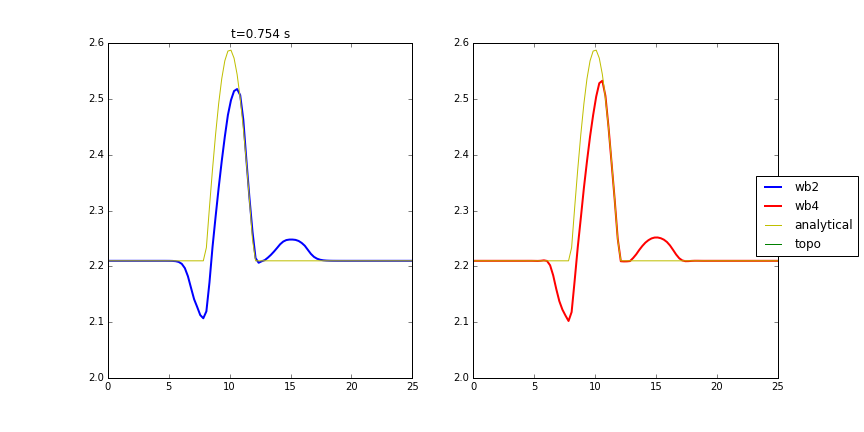
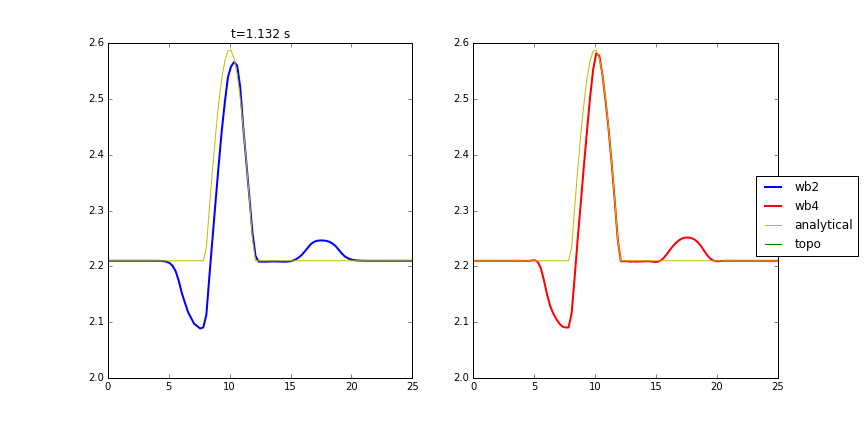
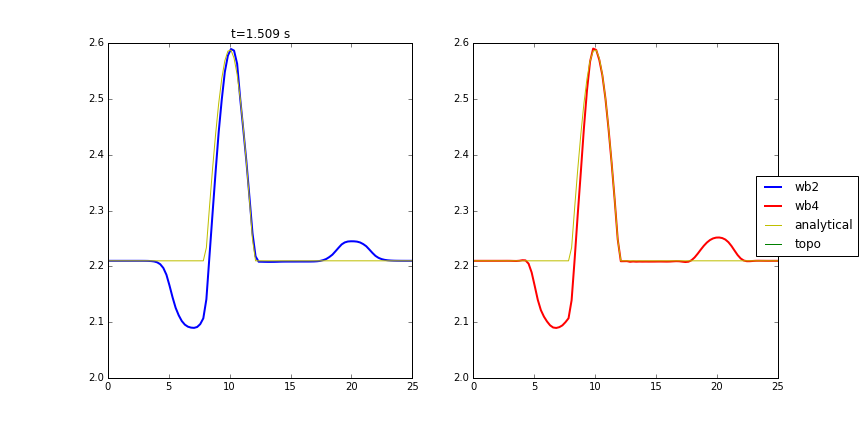
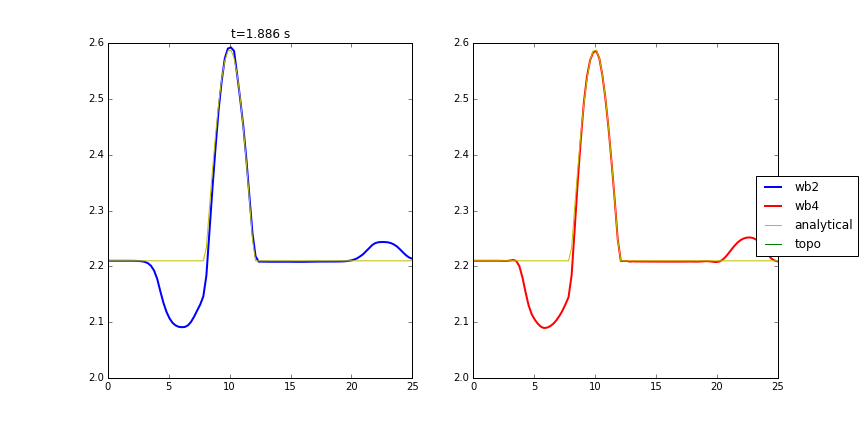
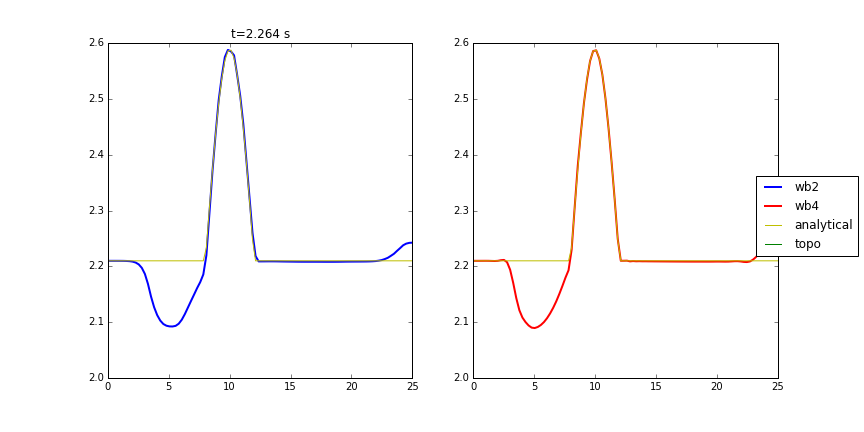
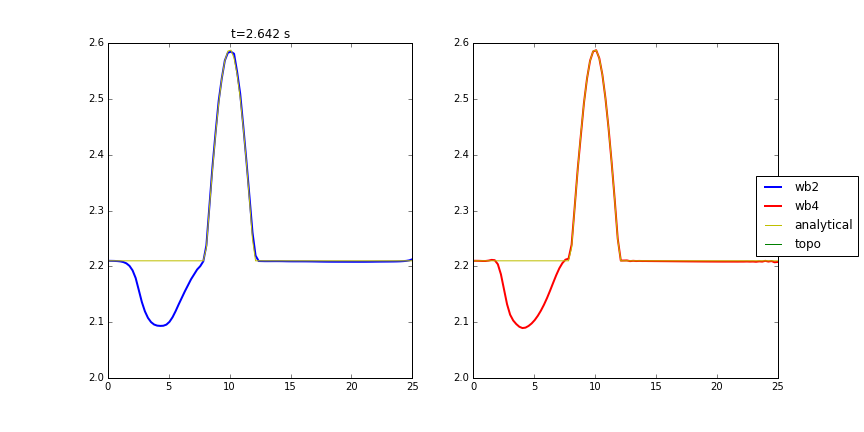
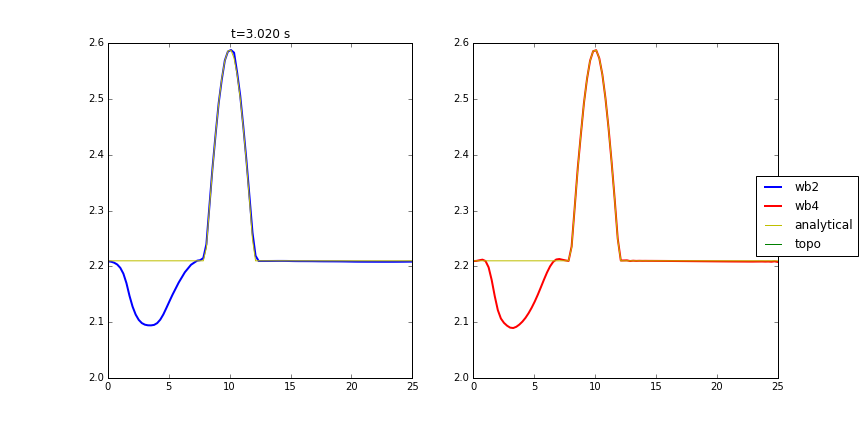
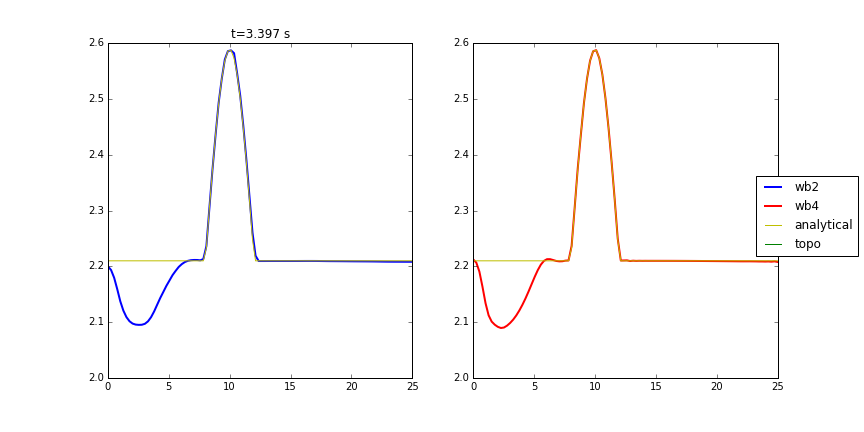
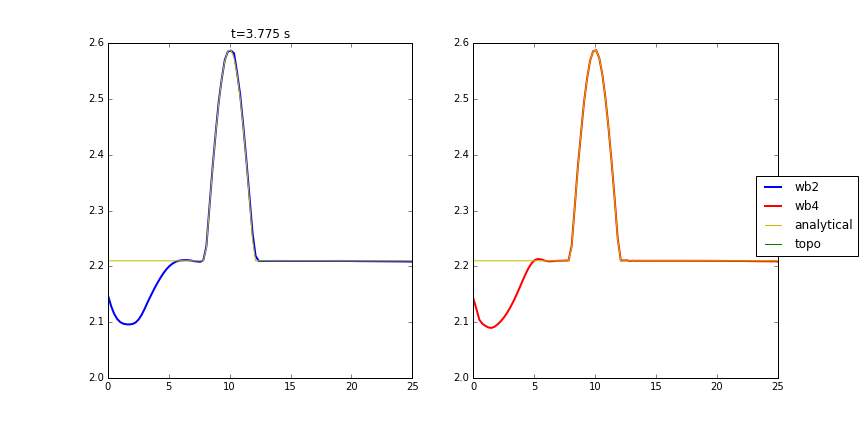
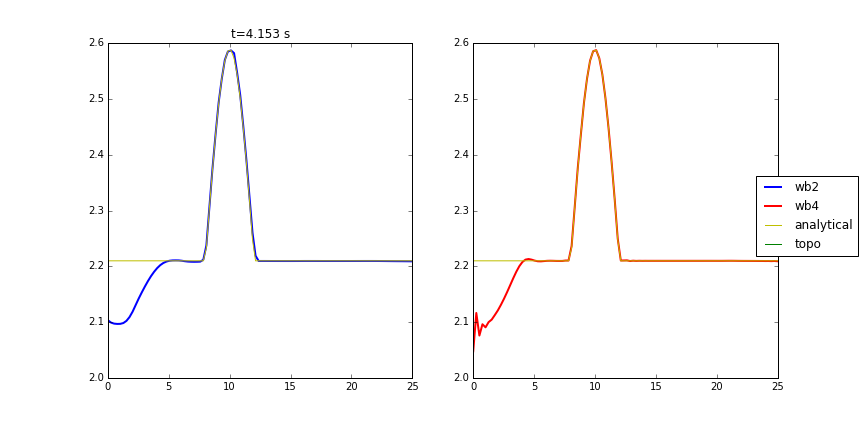
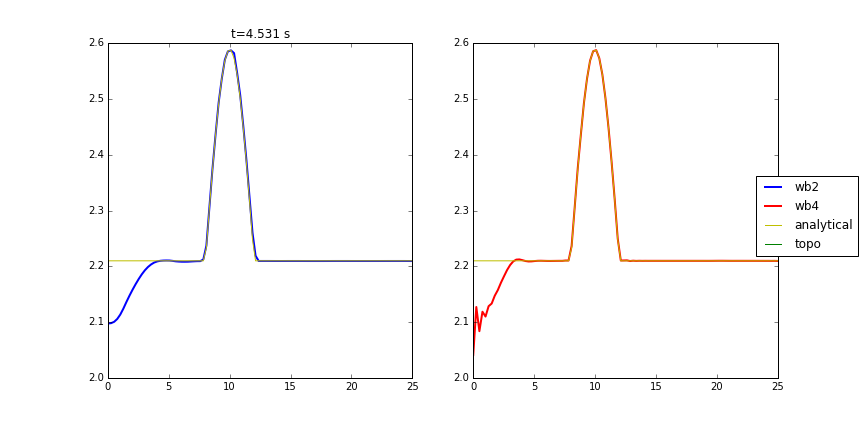
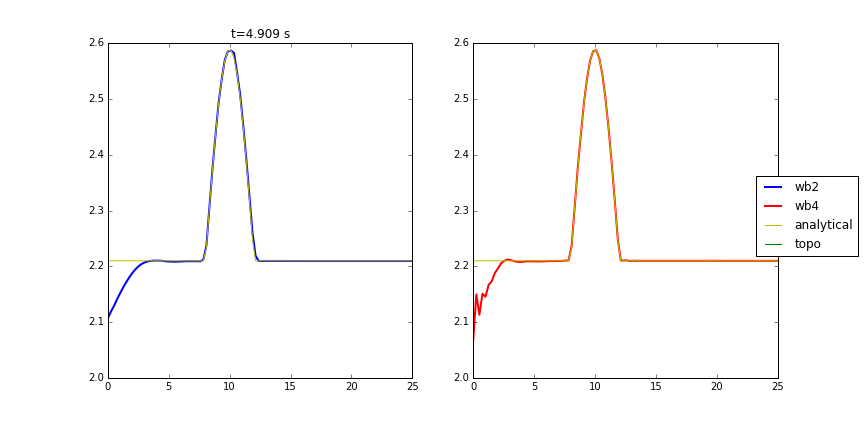
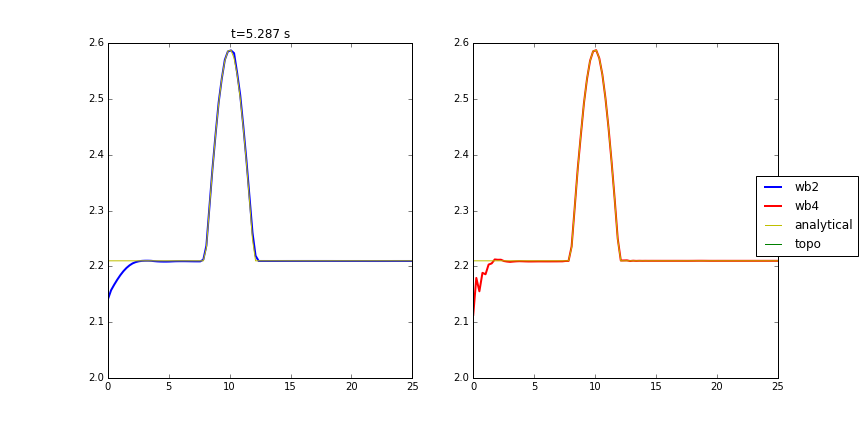
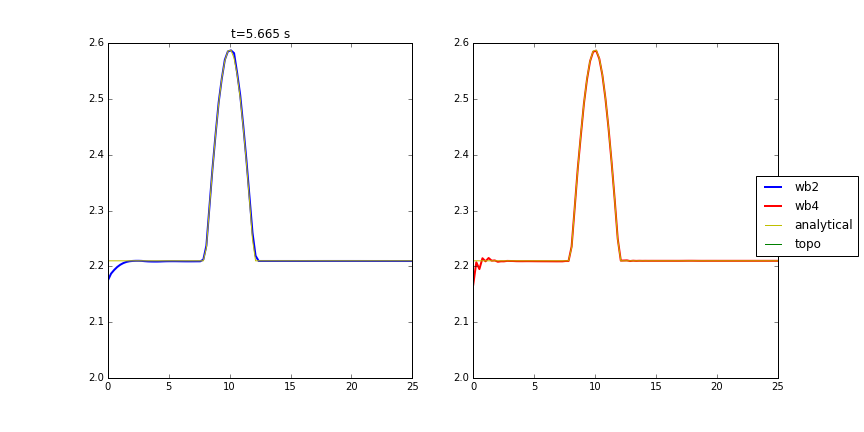
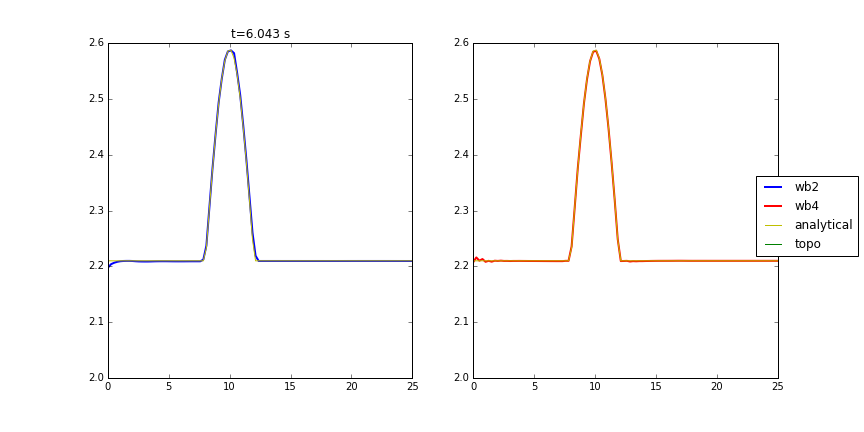
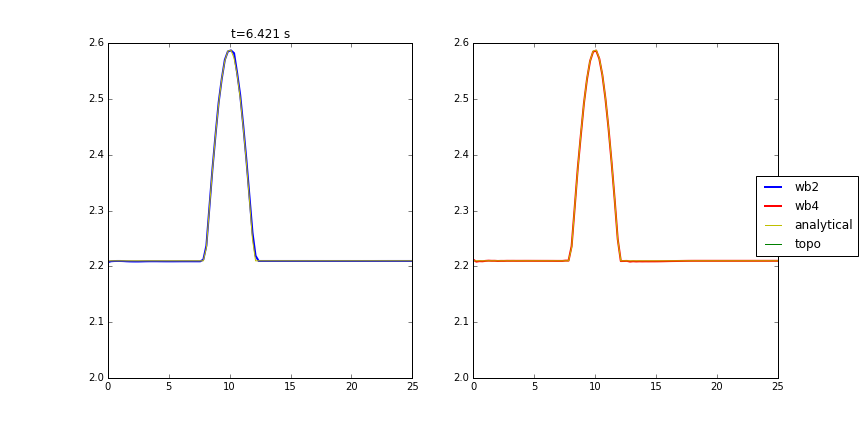
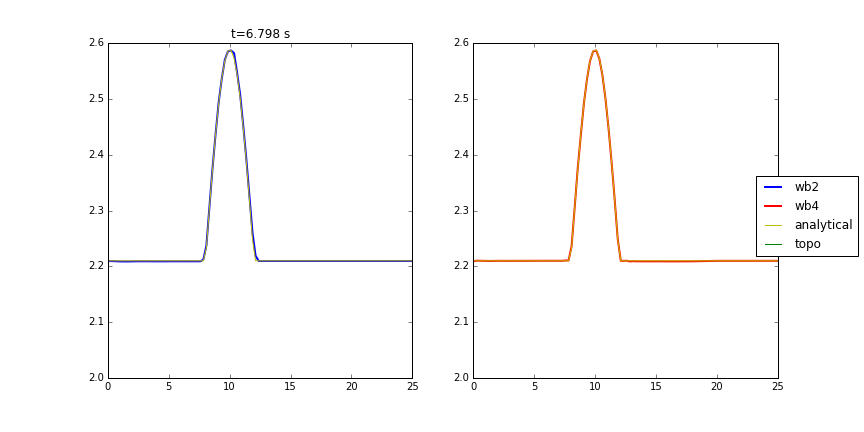
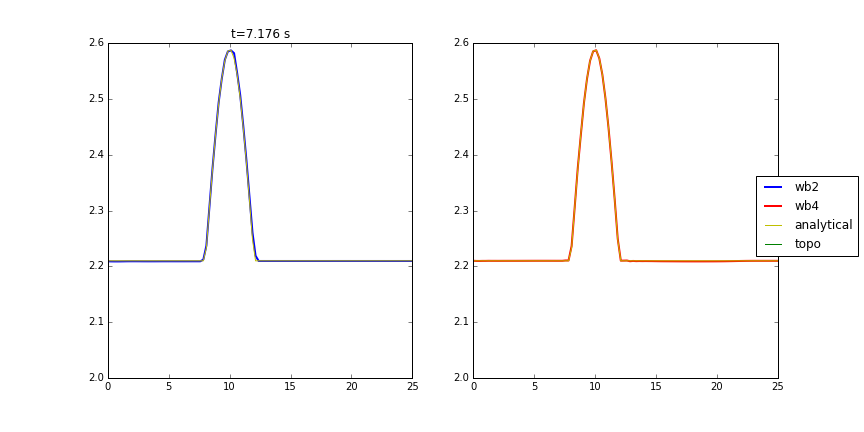
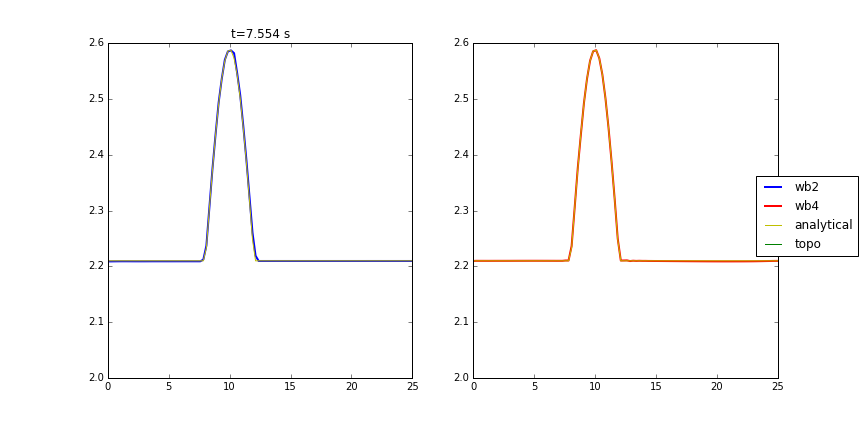
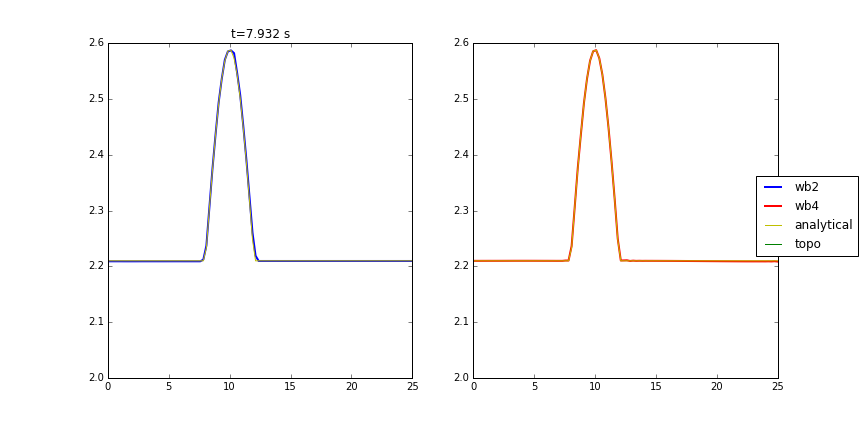
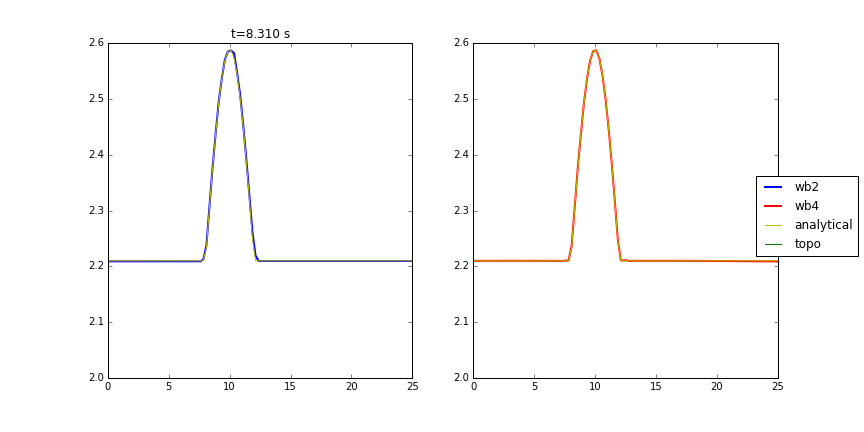
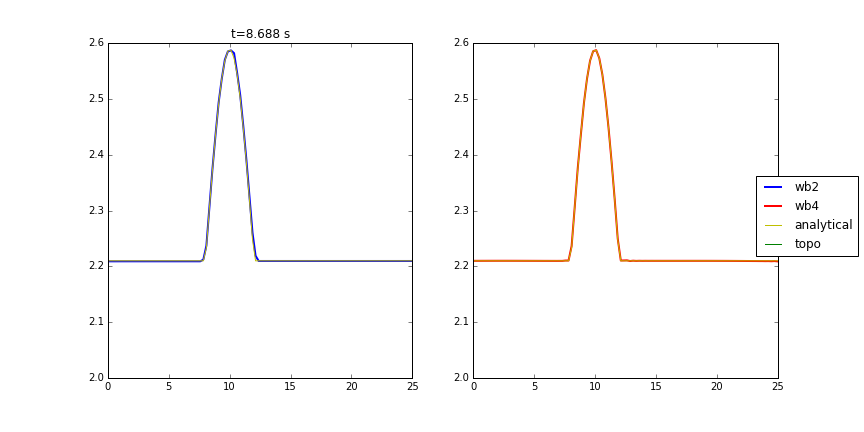
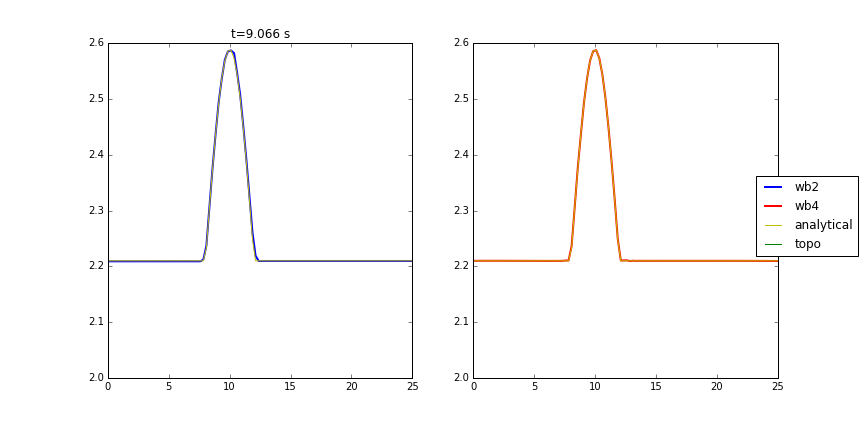
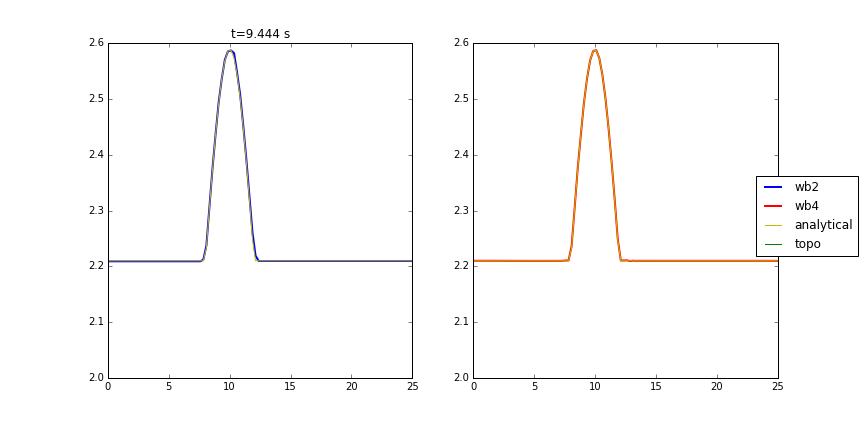
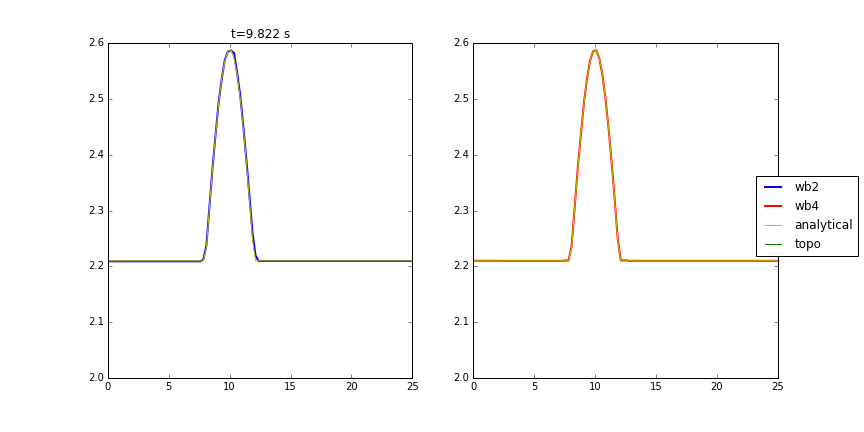
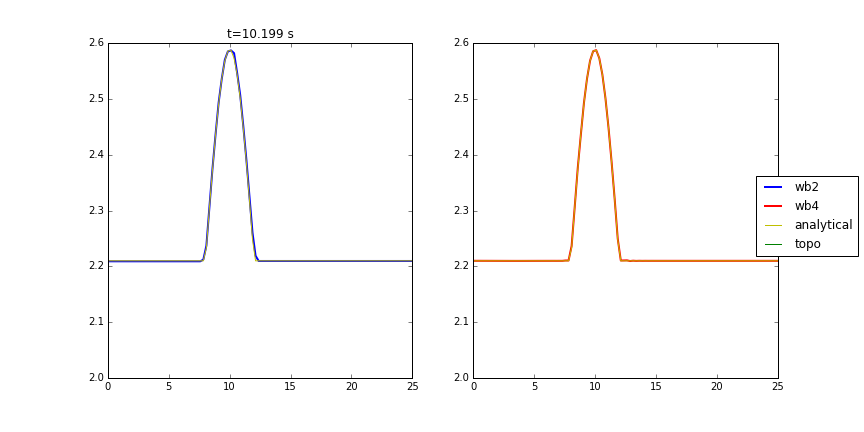
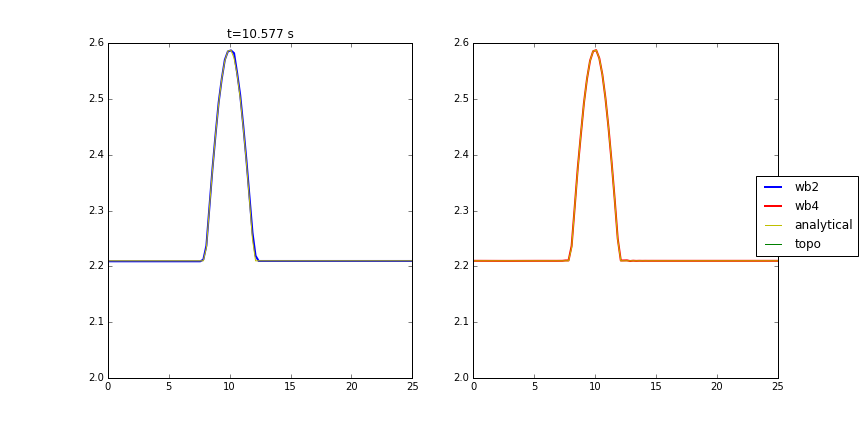
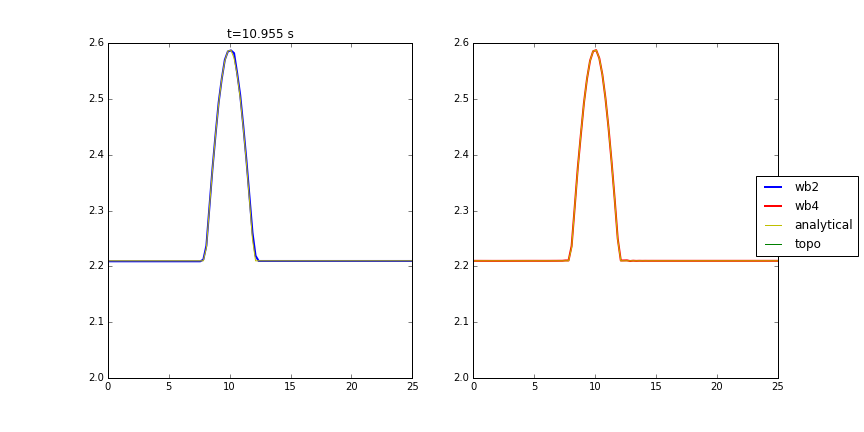

In [20]:
from matplotlib import animation
from JSAnimation import IPython_display

fig = plt.figure(figsize=(12,6))
# ax = plt.axes(xlim=(0, 25), ylim=(-0.1,2.1))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
line_wb2, = ax1.plot([], [], 'b-',lw=2)
line_wb4, = ax2.plot([], [], 'r-',lw=2)
line_a2 , = ax1.plot(x, ua[:,0], 'y-')
line_a4 , = ax2.plot(x, ua[:,0], 'y-')
lineb1, = ax1.plot(x,d0,'g')
lineb2, = ax2.plot(x,d0,'g')
timetxt = ax1.set_title('t=')
ax1.set_xlim(0,25)
ax2.set_xlim(0,25)
# ax1.set_ylim(1.85,2.1)
# ax2.set_ylim(1.85,2.1)

ax1.set_ylim(2, 2.6)
ax2.set_ylim(2, 2.6)


def animate(i):
    i = min(i*10,nt-1)
    line_wb2.set_data(x, u2[i,2:-2])
    line_wb4.set_data(x, u4[i,3:-3])
    timetxt.set_text('t=%.3f s'%t2[i])
    return line_wb2, line_wb4

fig.legend((line_wb2,line_wb4,line_a2, lineb1),("wb2", "wb4", "analytical", "topo"),loc='right')
animation.FuncAnimation(fig, animate, frames=nt/10, interval=200)

* We see oscillations in the boundaries that come from the fact that we are not using slope limiters in the 4th order.
* When including using the limiters of Bonneton et al. (2011) I'm getting errors that are bigger than with the 2nd order but no oscillations. 
* The increased errors can be seen to come from a small shift in the boundary conditions, so they are not respected with precision. Also I saw some numerical artifacts in the slope change.
* Another thing is that when using $np.sign(u)min(|u|,|v|,|w|)$  in the slope limiter $L$, instead of the original one, gave same results as with the 2nd order scheme.